In [1]:
import funzioni02 as f2
import funzioni01 as f1
import qiskit.quantum_info as qi
import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_sim_jakarta = sim_noisy_jakarta 
backend = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

### definisco tutti i circuiti

In [4]:
### definisco i parametri fissati per la realizzazione del grafico
shots=8192
reps=1  # al massimo 10
precision=20
steps=100
backend_aus=backend_sim_jakarta
check=["copy_check", [0,2,4]]
evo_type="complete_evolution" # "column_evolution" or "complete_evolution" or "trotter_steps"

### definisco i valori di steps corrispondenti ai punti che volgio acquisire
time_range=np.linspace(0.01,np.pi,5)
n_t=len(time_range)

### creo tutti i circuiti
qcs_times=[]
qcs_times_na=[]

qcs__=[]

### le liste qcs_steps e qcs_steps_na conterranno tutti i circuiti di evoluzione reps volte

for _ in range(reps):
    for time in time_range:
        
        qcs_aus, qcs_na_aus = f2.evolution_tomo(type=evo_type, N_steps=steps, tempo=time, precision=precision, initial_state='110', check=check)

        qcs_times.append(qcs_aus)
        qcs_times_na.append(qcs_na_aus)

### definisco il circuito di evoluzione a tre qubit che servirà per calcolare lo stato finale esatto
        '''
        U = f2.Trotter_N_approx(steps=steps, tempo=time, precision=precision)

        U2=[
            [U[3*8+3],U[3*8+5],U[3*8+6],0],
            [U[5*8+3],U[5*8+5],U[5*8+6],0],
            [U[6*8+3],U[6*8+5],U[6*8+6],0],
            [0,0,0,1]
        ]

        qc=QuantumCircuit(2, name="U")
        qc.unitary(U2,[0,1])    
        trans_qc=transpile(qc,basis_gates=['cx','x','sx','rz']) 

        qr__ = QuantumRegister(3)
        qc__ = QuantumCircuit(qr__)

        qc__.x([qr__[1],qr__[2]])

        qc__.append(trans_qc, [qr__[0],qr__[1]])
        qc__.append(f2.Mdg_circquit().inverse(),[qr__[0],qr__[1],qr__[2]])


        qcs__.append(qc__)
        '''

In [5]:
qcs_calibs, meas_calibs = f2.calibration_cirquits(evo_type, check[1])
state_lables = f2.bin_list(3+len(check[1]))

In [6]:
jobs_evo=[]

for qcs in qcs_times:
    job=execute(qcs, backend=backend_aus, shots=shots)
    jobs_evo.append(job)

job_cal=execute(meas_calibs, backend=backend_aus, shots=shots)# initial_layout=[0,1,2,3,4,5])#check[1]+[1,3,5])
job_cal_our=execute(qcs_calibs, backend=backend_aus, shots=shots)#, initial_layout=[0,1,2,3,4,5])


In [7]:
meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels=state_lables)
meas_fitter_our = mc.CompleteMeasFitter(job_cal_our.result(), state_labels=state_lables)


#target_state = (One^Zero^One).to_matrix()


fids=np.zeros([n_t,reps,4])
fids_mean=np.zeros([n_t,4])
fids_dev=np.zeros([n_t,4])

i=0
for job in jobs_evo:
    
    new_res, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['011','110','101'], meas_fitter=meas_fitter)
    new_res_our, new_res_nm = f2.mitigate(job.result(), Measure_Mitig="yes", ancillas_conditions=['011','110','101'], meas_fitter=meas_fitter_our)
    new_res_not_mitigated = f2.mitigate(job.result(), Measure_Mitig="no", ancillas_conditions=f2.bin_list(3))

    target_state = f1.final_state_vector(N_steps=steps, time=time_range[i], initial_state='110')

    fid = f2.fidelity_count(new_res_not_mitigated, qcs_times_na[i], target_state)
    fids[i%n_t][i//n_t][0] += fid

    fid = f2.fidelity_count(new_res_nm, qcs_times_na[i], target_state)
    fids[i%n_t][i//n_t][1] += fid

    fid = f2.fidelity_count(new_res, qcs_times_na[i], target_state)
    fids[i%n_t][i//n_t][2] += fid

    fid = f2.fidelity_count(new_res_our, qcs_times_na[i], target_state)
    fids[i%n_t][i//n_t][3] += fid
    
    i+=1

In [ ]:
for i in range(4):
    for j in range(n_t):
        fids_mean[j,i]=np.mean(fids[j,:,i])
        fids_dev[j,i]=np.std(fids[j,:,i])

In [ ]:
print((One^Zero^One).to_matrix())
for i in range(10):
    print(i)
    l=qi.Statevector.from_instruction(qcs__[i])
    print(l)
    print(f1.final_state_vector(N_steps=30, time=time_range[i]))

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
0
Statevector([ 1.46357568e-30+3.14378984e-31j,
              1.49933845e-17-2.13513493e-17j,
              5.59781208e-19+4.15692414e-20j,
             -1.97966803e-04+2.66613337e-06j,
              5.08008583e-21+1.64915438e-24j,
             -2.01966536e-04-1.99960002e-02j,
              9.99600040e-01-1.99960002e-02j,
              7.73675742e-15+1.10058318e-15j],
            dims=(2, 2, 2))
Statevector([-2.83216230e-16-1.11565391e-16j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              2.06644838e-04+1.46947777e-06j,
              0.00000000e+00+0.00000000e+00j,
             -2.06631520e-04+1.99958655e-02j,
             -9.99800020e-01+1.33171867e-06j,
              0.00000000e+00+0.00000000e+00j],
            dims=(2, 2, 2))
1
Statevector([-2.45740498e-18+9.02452028e-19j,
              1.64359868e-17-1.62017262e-17j,
             -6.03752213e-18-6.01855506e-18j,
      

In [ ]:
plt.errorbar(time_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")
plt.errorbar(time_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")
plt.errorbar(time_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
plt.errorbar(time_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
plt.plot([0,np.pi],[1,1],color="gray")
plt.legend()
plt.grid()

plt.show()

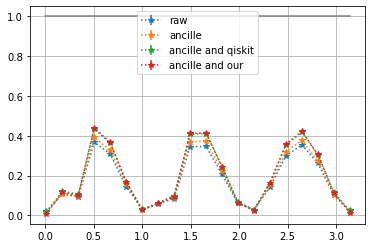

In [ ]:
plt.errorbar(time_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")
plt.errorbar(time_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")
plt.errorbar(time_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
plt.errorbar(time_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
plt.plot([0,np.pi],[1,1],color="gray")
plt.legend()
plt.grid()

plt.show()

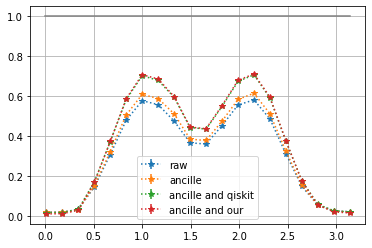

In [ ]:
plt.errorbar(time_range, fids_mean[:,0],fids_dev[:,0],linestyle=':',marker="*",label="raw")
plt.errorbar(time_range, fids_mean[:,1],fids_dev[:,1],linestyle=':',marker="*",label="ancille")
plt.errorbar(time_range, fids_mean[:,2],fids_dev[:,2],linestyle=':',marker="*",label="ancille and qiskit")
plt.errorbar(time_range, fids_mean[:,3],fids_dev[:,3],linestyle=':',marker="*",label="ancille and our")
plt.plot([0,np.pi],[1,1],color="gray")
plt.legend()
plt.grid()

plt.show()

In [ ]:
if check==[0] or check==0:
    c_auss="noc" 
else:
    c_auss="yesc"

dati=("#%d_%d_%d_%.4f_%s_%s \n" %(shots, reps, precision, steps, c_auss, evo_type))
nome="fid_vs_time_19-02_01.txt"

#f = open("dati/" + nome, "w")
f.write(dati)

for i in range(n_t):
    f.write("%d " %(time_range[i]))
    for j in range(4):
        f.write("%.5f " %(fids_mean[i,j]))
        f.write("%.5f " %(fids_dev[i,j]))
    f.write("\n")

f.close()

NameError: name 'f' is not defined